In [1]:
# initializing all libraries 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
# loading the lab dataset

unilab_df = pd.read_csv('/Users/sashacrowe/codebase-ih/lab-eda-univariate/amz_uk_price_prediction_dataset.csv')

In [3]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

**What are we looking at** (using what I know from the last lab)  

uid -> unique id index -> int   
asin -> serial id (with letters) -> string   
title -> name of prod -> string   
stars -> review -> float   
price -> float   
isBestSeller -> boolean with true = best seller   
boughtInLastMonth -> categorical var but listed as int   
category -> prod category var as string   

In [4]:
unilab_df['boughtInLastMonth'].value_counts()

boughtInLastMonth
0        2230204
50         75790
100        58578
200        24200
300        13650
400         8836
1000        8692
500         6110
600         4320
700         3121
2000        2550
800         2456
900         2070
3000        1130
4000         634
5000         430
10000        259
6000         223
7000         150
8000         116
9000          97
20000         27
50000          3
30000          3
40000          2
Name: count, dtype: int64

## Part 1: Analyzing Best-Seller Trends Across Product Categories
**Objective:** Understand the relationship between product categories and their best-seller status.    

1. **Crosstab Analysis:**
- Create a crosstab between the product category and the isBestSeller status

In [5]:
# My original crosstab
crosstab_w5 = pd.crosstab(unilab_df['category'],unilab_df['isBestSeller'])

# Adding a column for the proportion of True values
crosstab_w5['BestSellers'] = round((crosstab_w5[True] / (crosstab_w5[True] + crosstab_w5[False]))*100,2)

crosstab_w5

isBestSeller,False,True,BestSellers
category,,,
3D Printers,247,1,0.40
3D Printing & Scanning,4065,2,0.05
Abrasive & Finishing Products,245,5,2.00
Action Cameras,1696,1,0.06
Adapters,251,3,1.18
...,...,...,...
Wind Instruments,243,7,2.80
Window Treatments,234,5,2.09
Women,17559,213,1.20


In [6]:
w5crosstab_sorted = crosstab_w5.sort_values(by='BestSellers', ascending=False)
w5crosstab_sorted.head(10)

isBestSeller,False,True,BestSellers
category,,,
Grocery,9008,556,5.81
Smart Home Security & Lighting,98,6,5.77
Health & Personal Care,9017,552,5.77
Mobile Phone Accessories,248,11,4.25
Power & Hand Tools,8353,306,3.53
"Billiard, Snooker & Pool",241,8,3.21
Pet Supplies,9152,285,3.02
Home Brewing & Wine Making,239,7,2.85
Wind Instruments,243,7,2.80


- Are there categories where being a best-seller is more prevalent?    
Yes, the top 5 best-selling categories are Grocery, Smart Home Security & Lighting, Health & Personal Care, Mobile Phone Accessories, & Power & Hand Tools

2. **Statistical Tests:**
- Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category   
With a p-value less than 0.05 we can reject the null hypothesis, meaning the two categorical variables have a significant association

In [7]:
from scipy.stats import chi2_contingency

chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_w5)

chi2_statistic, chi2_p_value

(50605.3673806634, 0.0)

- Compute Cramér's V to understand the strength of association between best-seller status and category   
There is a weak association between the two categorical variables 

In [8]:
from scipy.stats.contingency import association
crosstab_cramer = pd.crosstab(unilab_df['category'],unilab_df['isBestSeller'])
association(crosstab_cramer, method="cramer")

0.1222829439760564

3. **Visualizations:**

- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

In [24]:
crosstab_top = pd.crosstab(unilab_df['category'],unilab_df['isBestSeller']).sort_values(by=True, ascending=False).head(10)

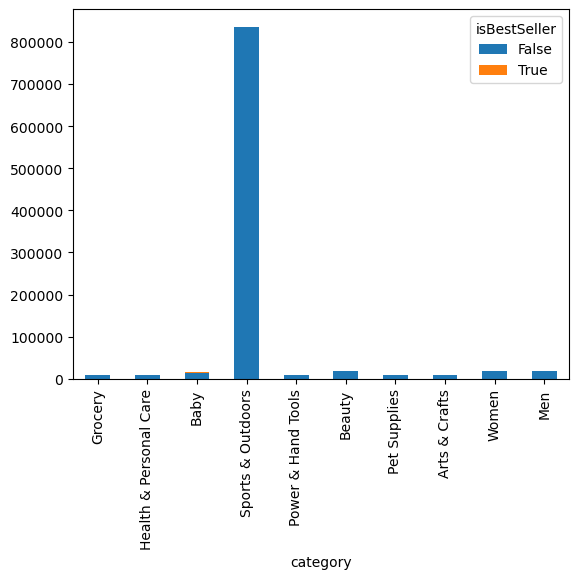

In [25]:
crosstab_top.plot(kind="bar", stacked=True)
plt.show()

## Part 2: Exploring Product Prices and Ratings Across Categories and Brands
**Objective:** Investigate how different product categories influence product prices.

**Preliminary Step:** Remove outliers in product prices.    

For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

In [26]:
Q1 = unilab_df['price'].quantile(0.25)
Q3 = unilab_df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_df = unilab_df[(unilab_df['price'] >= lower_bound) & (unilab_df['price'] <= upper_bound)]

In [27]:
filtered_df.shape

(2115963, 9)

1. **Violin Plots:**

- Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
- Which product category tends to have the highest median price? Don't filter here by top categories.   
It seems like the 'men' category has the highest median price

In [43]:
top20_cat = filtered_df['category'].value_counts().sort_values(ascending=False).head(20).index
top20_cat_df = filtered_df[filtered_df['category'].isin(top20_cat)]

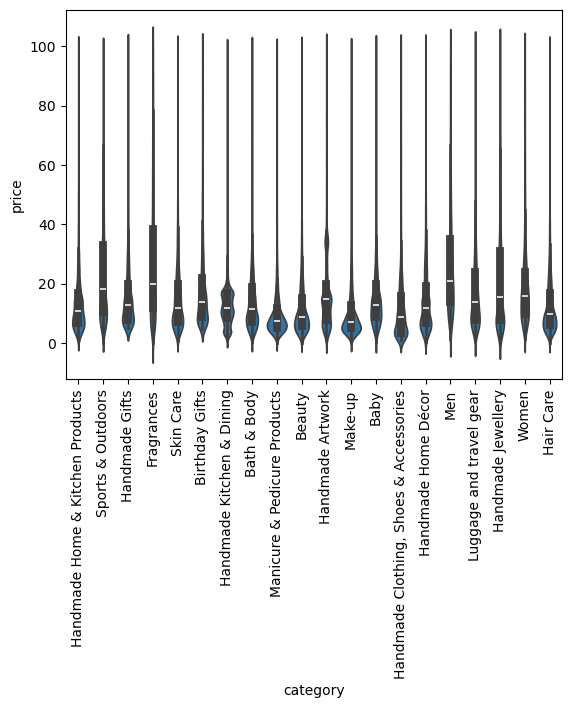

In [47]:
sns.violinplot(data=top20_cat_df, y='price', x='category')
plt.xticks(rotation=90)
plt.show()

## Bar Charts
- Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
- Which product category commands the highest average price? Don't filter here by top categories.    
It appears that the 'Sports & Outdoors' category has the highest average price

In [56]:
top10_cat = filtered_df['category'].value_counts().sort_values(ascending=False).head(10).index
top10_cat_df = filtered_df[filtered_df['category'].isin(top10_cat)]
top10_cat_df.groupby('category')['price'].mean().round(2)

category
Bath & Body                               14.68
Beauty                                    12.52
Birthday Gifts                            18.60
Hair Care                                 13.46
Handmade Clothing, Shoes & Accessories    12.96
Handmade Gifts                            17.40
Make-up                                   10.61
Manicure & Pedicure Products              10.23
Skin Care                                 15.65
Sports & Outdoors                         25.17
Name: price, dtype: float64

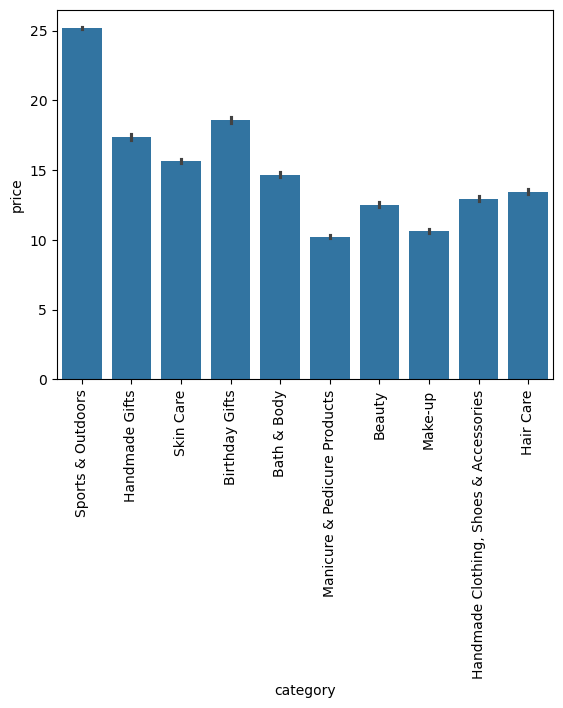

In [60]:
sns.barplot(data=top10_cat_df, x='category', y='price')
plt.xticks(rotation=90)
plt.show()

3. **Box Plots:**

- Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
- Which category tends to receive the highest median rating from customers? Don't filter here by top categories.   
It appears that the 'Skin Care', 'Bath & Body', & 'Beauty' categories have the hisgest meadian ratings

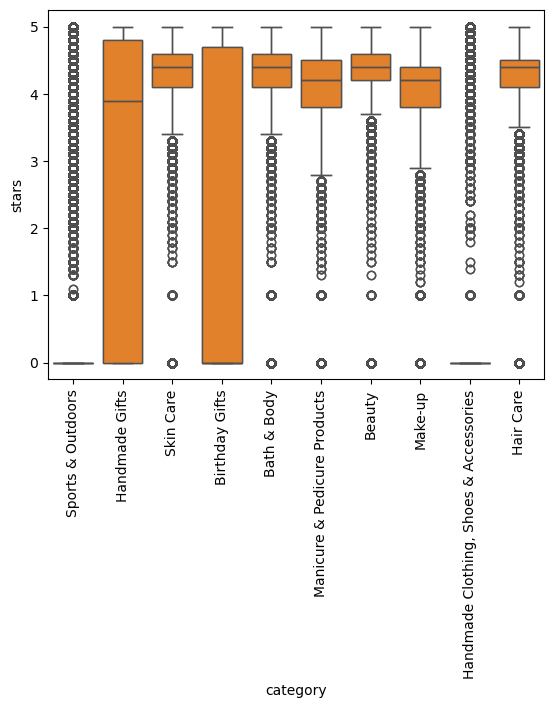

In [62]:
sns.boxplot(data=top10_cat_df, x='category', y='stars')
plt.xticks(rotation=90)
plt.show()

## Part 3: Investigating the Interplay Between Product Prices and Ratings
**Objective:** Analyze how product ratings (stars) correlate with product prices.

1. **Correlation Coefficients:**

- Calculate the correlation coefficient between price and stars.
- Is there a significant correlation between product price and its rating?   
There is a slight negative trend present, but as the overall value is near 0 this would indicate little linear correlation

In [63]:
correlation = filtered_df['price'].corr(filtered_df['stars'])
correlation

-0.0776729987818137

2. **Visualizations:**

- Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?   
It is rather difficult to make out any sort of pattern, maybe if the 0 ratings were dropped it might help, but otherwise if forced to give some insight it looks like the range of ratings varies more for cheaper products whereas for more expensive products the ratings are less evenly spread out

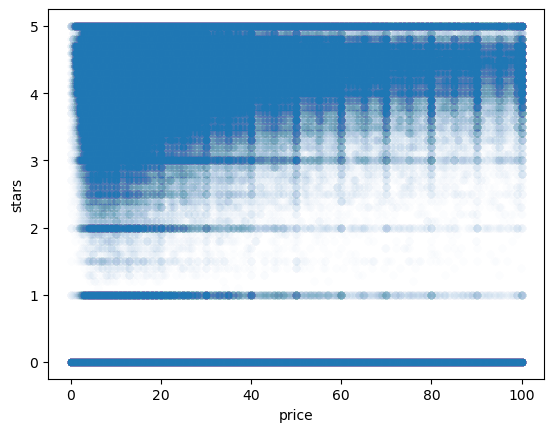

In [68]:
sns.scatterplot(data=filtered_df, x='price', y='stars', alpha=.01)
plt.show()

- Use a correlation heatmap to visualize correlations between all numerical variables.

In [72]:
num_df = filtered_df.drop(columns=['uid', 'asin', 'title','category'])

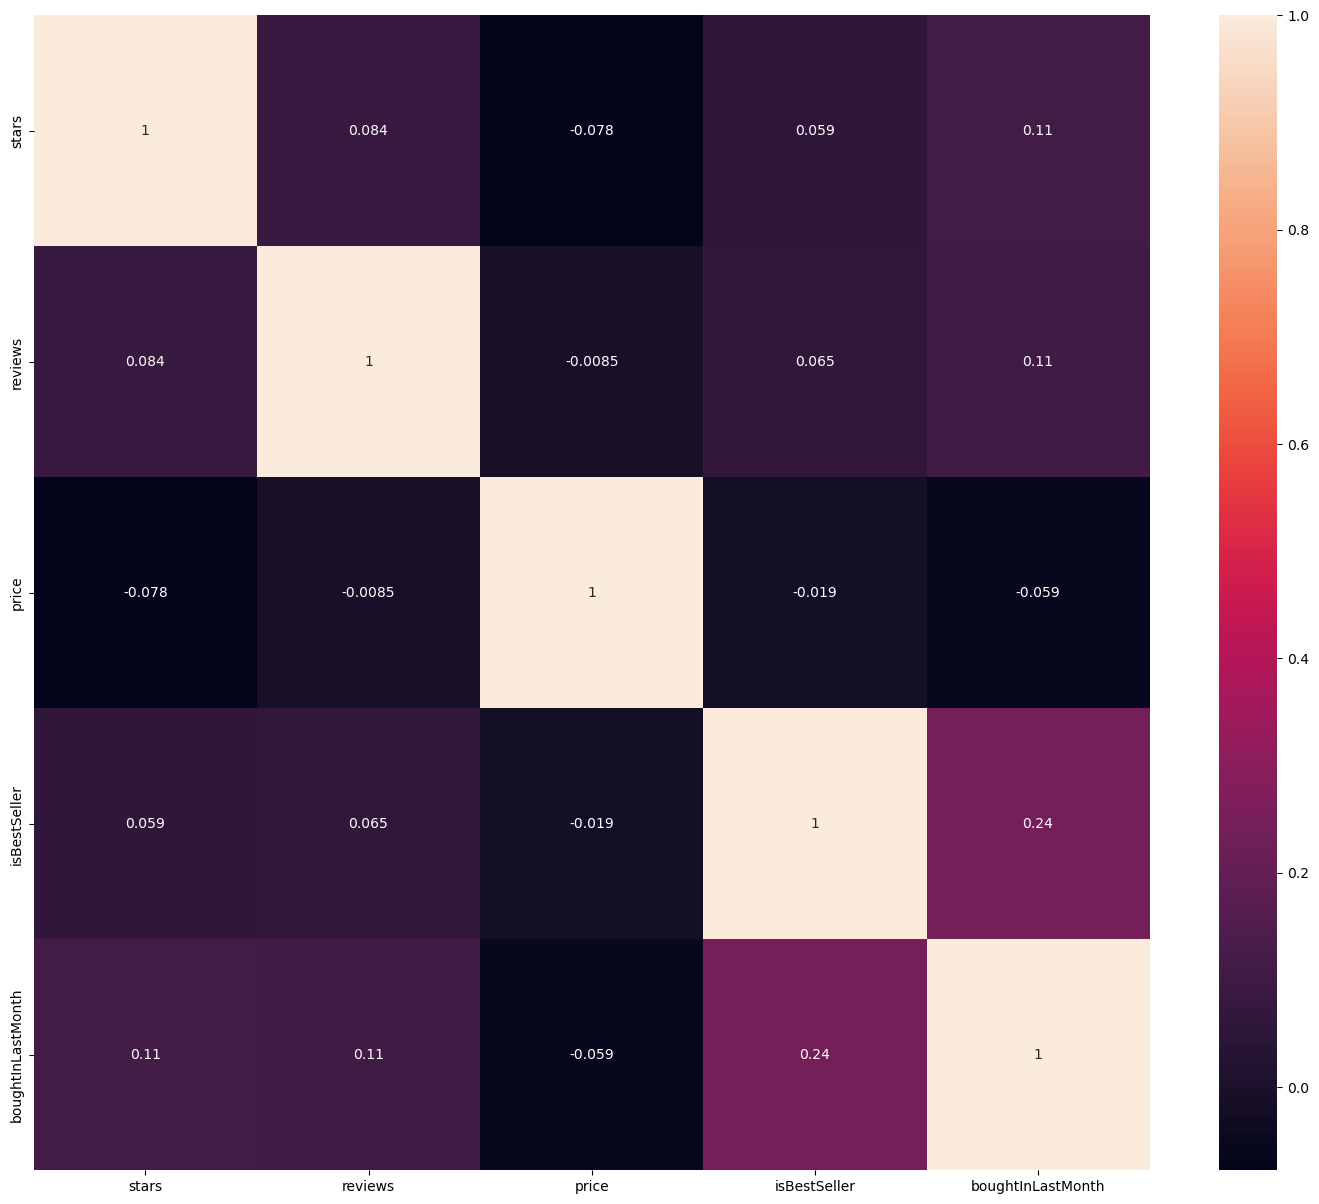

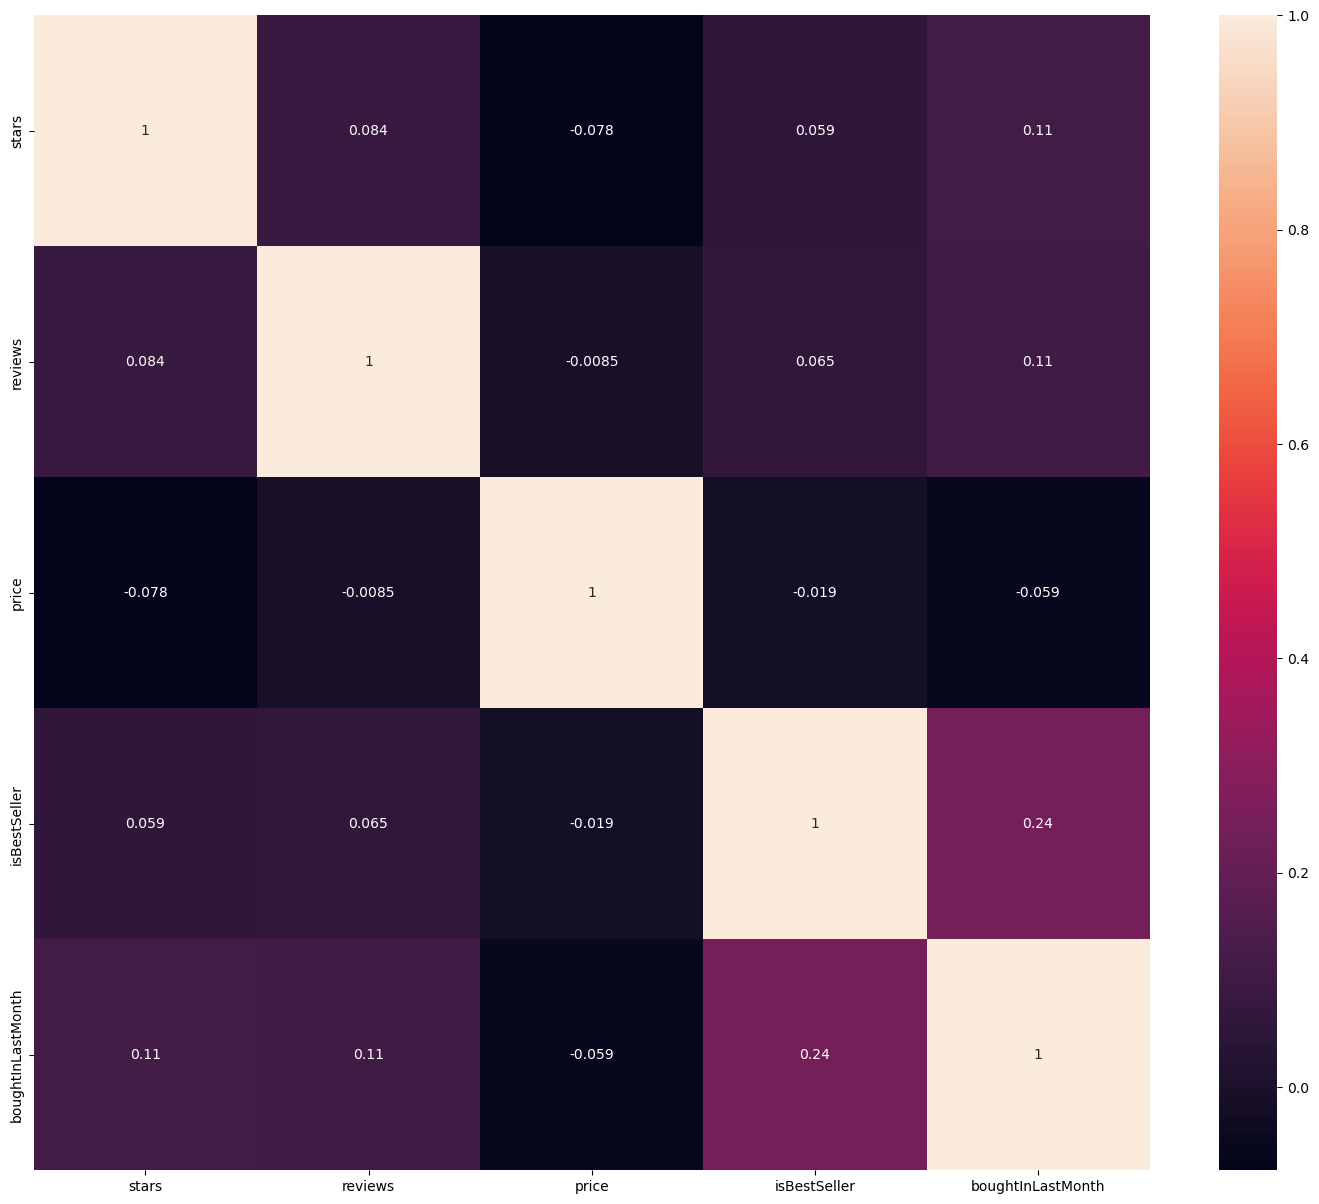

In [74]:
correlation_matrix = num_df.corr()

# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(18, 15))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True)
plt.show()

- Examine if product prices typically follow a normal distribution using a QQ plot.

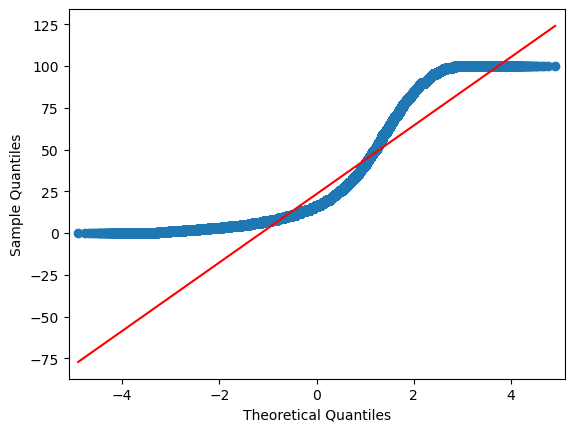

In [76]:
import statsmodels.api as sm

# Generating a Q-Q plot for 'SalePrice' to check if its distribution follows a normal distribution
sm.qqplot(filtered_df['price'], line='s');
plt.show()